<a href="https://colab.research.google.com/github/weihanchen/google-colab-python-learn/blob/main/jupyter-examples/spacy_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 【自然語言處理NLP - spaCy系列】善用ChatGPT幫我們訓練出自訂的Name Entity Recognition實體
回顧上一個篇章「[【自然語言處理NLP】初探強大的工具庫spaCy， 讓機器讀懂我們的語言]()」我們初步學習`spaCy`這套工具，在尾端進行NER時我們也發現到現有的NER模型並沒有辦法滿足我們的需求，
導致有一些實體未被識別出來， 因此這次的任務就是設法進行訓練， 讓我們想要被識別的實體可以被進行識別。


這個篇章主要在示範如何利用`spaCy`進行訓練，並非真正要準確做到滿分的NER，因此過程中將以「最簡短的例句」及「CPU」訓練方式完成。


## 安裝相關套件及下載模型

以下幾個步驟我們先將該準備的模型及語句準備好， 再進行調優與訓練。

In [56]:
# 安裝spacy
%pip install spacy

# 下載Transfromer技術的中文語言模型
!python -m spacy download zh_core_web_trf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-04-28 09:09:05.072133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.0/603.0 MB 1.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_lg')


## 載入模型並解析

In [65]:
import spacy

# 載入模型
nlp_zh = spacy.load('zh_core_web_trf')

# 對中文語句進行解析
doc = nlp_zh('台灣是一個位於亞洲東部的島嶼國家。')

## NER實體識別

我們可以看到實體僅被識別出「台灣」、「亞洲」， 但我們更希望「東部」跟「國家」也可以被識別出來， 那麼可以怎麼做呢？


In [66]:
from spacy import displacy
     
# 台灣是一個位於亞洲東部的島嶼國家。
displacy.render(doc, style="ent", jupyter=True)

## 設計訓練資料

假設: 其中「亞洲東部」我們期望實體為「LOC」， 而「國家」為「ORG」。

### 小技巧
- 利用ChatGPT幫我們列出「東部國家」的一些例句， 如何給予提示(Prompt)，就讓大家創意發揮囉，例如: 請幫我列出5句關於「亞洲東部國家的一些特色」。
- 將這些例句藉由「[spacynerannotate](https://agateteam.org/spacynerannotate/)」這套工具幫我快速人工標出實體並轉換成`spaCy`訓練NER的格式， 雖然有點不太好用， 但為了快速Demo我們就將就點使用吧，另一套更好用的工具是「[prodigy](https://prodi.gy/)」，下次再獨立開一個篇章來玩玩這個標注套件。
- 將轉換格式後的語句以`train`儲存起來。

P.S [spacynerannotate](https://agateteam.org/spacynerannotate/)這套工具轉出來之後，記得要把`entities`欄位拿掉，留下陣列的值，避免新版spaCy格式錯誤。


```bash
# 錯誤的格式：
("在亞洲東部國家，教育非常重要，其高水平的教育體系吸引著世界各地的學生前來留學。",{"entities":[(3,5,"LOC"),(5,7,"ORG")]})

# 正確的格式：
("在亞洲東部國家，教育非常重要，其高水平的教育體系吸引著世界各地的學生前來留學。",[(3,5,"LOC"),(5,7,"ORG")])

```

In [86]:
training_data = [
    ("台灣的風景都非常美麗",[(0,2,"GPE")]),
    ("亞洲東部國家的一些特色包括擁有豐富多彩的文化遺產和傳統習俗。",[(0,4,"LOC"),(4,6,"ORG")]),
    ("在亞洲東部國家，食品文化有著獨特的地位，其美食吸引著眾多遊客前來品嚐。",[(1,5,"LOC"),(5,7,"ORG")]),
    ("亞洲東部國家的經濟以製造業和出口為主，是全球經濟中的關鍵角色。",[(0,4,"LOC"),(4,6,"ORG")]),
]

## 轉換成spaCy的格式

請參考官方文件： [https://spacy.io/usage/training#training-data](https://spacy.io/usage/training#training-data)

以下的程式碼僅進行訓練集(train.spacy)的製作，開發集(dev.spacy)就得自行依樣畫葫蘆做一份，以便後續的訓練過程能夠順利完成。

當然我們也可以在後續的參數配置上將訓練集與開發集設定為同一份，雖然結果會造成自我感覺良好，但這邊只是概念的展示，就不多加著墨了。



In [88]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

nlp = spacy.blank("zh")

# the DocBin will store the example documents
db = DocBin()
for text, annotations in tqdm(training_data):
    _doc = nlp(text)
    ents = []
    for start, end, label in annotations:
        span = _doc.char_span(start, end, label=label)
        ents.append(span)
    _doc.ents = ents
    db.add(_doc)
db.to_disk("./train.spacy")

100%|██████████| 4/4 [00:00<00:00, 1170.69it/s]


## 配置訓練檔

我們先從官方勾選需要配置的訓練方式： 

P.S 這邊記得將`vectors="zh_core_web_lg"`改成`vectors="zh_core_web_trf"`


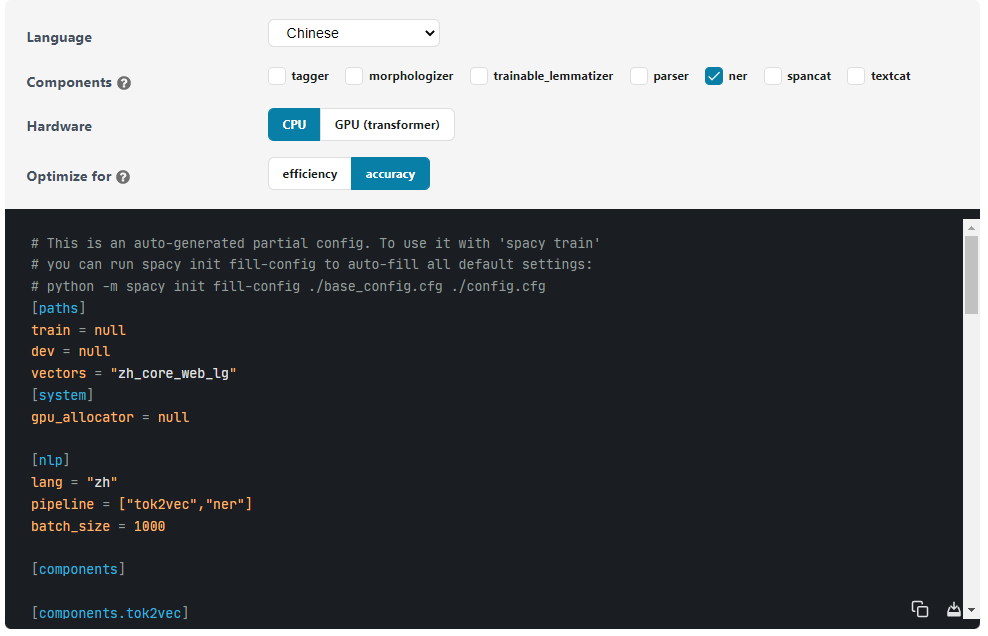



## 填充完整的配置

我們使用`spacy init`來進行填充。

In [77]:
!python -m spacy init fill-config base_config.cfg config.cfg

2023-04-28 09:40:39.981998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


## 進行訓練

In [89]:
!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./train.spacy

2023-04-28 09:58:46.670501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2023-04-28 09:58:49,641] [INFO] Set up nlp object from config
[2023-04-28 09:58:49,664] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-04-28 09:58:49,669] [INFO] Created vocabulary
[2023-04-28 09:58:57,993] [WARNING] [W112] The model specified to use for initial vectors (zh_core_web_trf) has no vectors. This is almost certainly a mistake.
[2023-04-28 09:58:58,169] [INFO] Added vectors: zh_core_web_trf
[2023-04-28 09:58:58,173] [INFO] Finished initializing nlp object
[2023-04-28 09:58:58,555] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER

## 載入訓練完的模型

這邊就載入最好的模型來看看吧

In [90]:
best_model = spacy.load(r"./output/model-last") #load the best model

## 重新進行NER辨識

結果如我們預期，分別將「台灣」、「亞洲東部」、「國家」這些實體給標示出來。

但目前是作弊方式，小資料量相似語句進行訓練當然能夠順利辨識，真實的標注方式可是很多狀況的，相似詞語標注不同的實體時，這些模糊資料如何訓練出較為精準的實體，就是NER的真正精髓所在。

In [91]:
from spacy import displacy

new_doc = best_model("台灣是一個位於亞洲東部的島嶼國家。")


# 台灣是一個位於亞洲東部的島嶼國家。
displacy.render(new_doc, style="ent", jupyter=True)

## 結語
這邊我們只是示範如何運用`spaCy`進行NER的模型訓練，實際上的訓練工法是有一套理論跟邏輯存在的，絕非我們範例中幾句例句就能夠標出準確的NER標籤，下次將嘗試介紹NER的訓練語句該如何設計，這樣一來才能真正的結合實務與理論，完成一個真正可用的系統。